In [16]:
import json
import os
files = {
    "12509": "/eos/atlas/unpledged/group-wisc/users/zhangr/Zy/cms/hzg/v1/12509/comb_hzg_plain_12509.root",
    "12538": "/eos/atlas/unpledged/group-wisc/users/zhangr/Zy/cms/hzg/v1/12538/comb_hzg_plain.root",
}
files = {
    "12509": "comb_hzg_plain_12509.root",
    "12538": "/eos/atlas/unpledged/group-wisc/users/zhangr/Zy/cms/hzg/v1/12538/comb_hzg_plain.root",
}
outdir = os.path.join(os.getcwd(), "likelihood_scan")
if not os.path.exists(outdir):
    os.makedirs(outdir)
cachedir = os.path.join(outdir, "cache")
if not os.path.exists(cachedir):
    os.makedirs(cachedir)

In [17]:
from quickstats.components import AnalysisBase
analysis = AnalysisBase(files["12509"], poi_name="r", data_name="data_obs",
                        config={"eps": 0.1, "optimize": 1})

INFO: Opening file "comb_hzg_plain_12509.root"
INFO: Loaded workspace "w"
INFO: Loaded model config "ModelConfig"
INFO: Loaded model pdf "model_s" from model config
INFO: Loaded dataset "data_obs" from workspace
INFO: Loaded nuisance parameters from model config
INFO: Loaded global observables from model config
INFO: Loaded parameters of interest from model config
INFO: Loaded observables from model config
INFO: POI set to "r"
INFO: Created ExtendedMinimizer("Minimizer") instance


In [18]:
import numpy as np

from quickstats.maths.numerics import str_encode_value

def get_poi_str(poi_val=None):
    if poi_val is None:
        poi_str = "uncond"
    else:
        poi_str = str_encode_value(round(poi_val, 8))
    return poi_str

def get_result(analysis, poi_val, cache_filename,
               load_snapshot, save_snapshot, cache_workspace):
    if load_snapshot is None:
        load_snapshot = AnalysisBase.kCurrentSnapshotName
    poi_str = get_poi_str(poi_val)
    filename = os.path.join(cachedir, cache_filename.format(poi_val=poi_str))
    new_snapshot = analysis.model.workspace.getSnapshot(save_snapshot)
    if os.path.exists(filename) and new_snapshot:
        result = json.load(open(filename))
        if ((('uncond_fit' in result) and (result['uncond_fit']['status'] == 0)) or
           (('cond_fit' in result) and (result['cond_fit']['status'] == 0))):
            print(f"INFO: Cached mu = {poi_str} result from {filename}")
            return result
    print(f"INFO: Performing fit at mu = {poi_str}")
    if poi_val is None:
        result = analysis.nll_fit(mode="uncond", snapshot_name=load_snapshot)
    else:
        result = analysis.nll_fit(poi_val=poi_val, mode="cond", snapshot_name=load_snapshot)
    json.dump(result, open(filename, "w"), indent=2)    
    analysis.save_snapshot(save_snapshot)
    print(f"INFO: Saved snapshot {save_snapshot}")
    analysis.save(cache_workspace, rebuild=True)
    return result

def smart_scan(analysis,
               poi_min=0, poi_max=5, step=0.2,
               cache_filename="mH_12509_mu_{poi_val}.json",
               snapshot_name="mu_{poi_val}",
               cache_workspace="mH_12509_cache_workspace.root",
               outfile="mH_12509_<poi_name>.json"):
    data = {'nll':[], 'qmu':[]}
    poi_name = analysis.poi.GetName()
    data[poi_name] = []
    cache_workspace_path = os.path.join(cachedir, cache_workspace)
    if os.path.exists(cache_workspace_path):
        print("INFO: Loading cached workspace.")
        minimizer_options = analysis.default_minimizer_options
        analysis= AnalysisBase(cache_workspace_path,
                               poi_name=analysis.poi.GetName(),
                               data_name=analysis.model.data.GetName())
        analysis.minimizer.configure(**minimizer_options)
    poi_values = np.arange(poi_min, poi_max + step, step)
    last_snapshot = snapshot_name.format(poi_val=get_poi_str(None))
    # unconditional fit
    uncond_result = get_result(analysis, poi_val=None, cache_filename=cache_filename,
                               load_snapshot=None, save_snapshot=last_snapshot,
                               cache_workspace=cache_workspace_path)

    muhat = uncond_result['uncond_fit']['muhat']['r']
    uncond_nll = uncond_result['uncond_fit']['nll']
    data[poi_name].append(muhat)
    data['nll'].append(uncond_nll)
    data['qmu'].append(0)
    closest_mu_index = np.argmin(np.abs(poi_values - muhat))
    # scan from best fit to poi max
    for poi_value in poi_values[closest_mu_index:]:
        save_snapshot = snapshot_name.format(poi_val=get_poi_str(poi_value))
        result = get_result(analysis, poi_val=poi_value, cache_filename=cache_filename,
                            load_snapshot=last_snapshot, save_snapshot=save_snapshot, cache_workspace=cache_workspace_path)
        data[poi_name].append(poi_value)
        nll = result['cond_fit']['nll']
        data['nll'].append(nll)
        data['qmu'].append(2*(nll - uncond_nll))
        last_snapshot = save_snapshot
    last_snapshot = snapshot_name.format(poi_val=get_poi_str(poi_val=None))
    # scan from poi min to best fit
    for poi_value in poi_values[:closest_mu_index][::-1]:
        save_snapshot = snapshot_name.format(poi_val=get_poi_str(poi_value))
        result = get_result(analysis, poi_val=poi_value, cache_filename=cache_filename,
                            load_snapshot=last_snapshot, save_snapshot=save_snapshot, cache_workspace=cache_workspace_path)
        data[poi_name].append(round(poi_value, 8))
        nll = result['cond_fit']['nll']
        data['nll'].append(nll)
        data['qmu'].append(2*(nll - uncond_nll))
        last_snapshot = save_snapshot
    fname = os.path.join(outdir, outfile.format(poi_name=poi_name))
    with open(fname, "w") as f:
        json.dump(data, f, indent=2)
    return data

In [31]:
result = smart_scan(analysis, poi_min=0, poi_max=6, step=0.2,
                    cache_filename="mH_12509_mu_{poi_val}.json",
                    snapshot_name="mu_{poi_val}",
                    cache_workspace="mH_12509_cache_workspace.root",
                    outfile="mH_12509_<poi_name>.json")

INFO: Loading cached workspace.
INFO: Opening file "/afs/cern.ch/work/c/chlcheng/Repository/hzycombination/notebooks/likelihood_scan/cache/mH_12509_cache_workspace.root"
INFO: Loaded workspace "w"
INFO: Loaded model config "ModelConfig"
INFO: Loaded model pdf "model_s" from model config
INFO: Loaded dataset "data_obs" from workspace
INFO: Loaded nuisance parameters from model config
INFO: Loaded global observables from model config
INFO: Loaded parameters of interest from model config
INFO: Loaded observables from model config
INFO: POI set to "r"
INFO: Created ExtendedMinimizer("Minimizer") instance
INFO: Cached mu = uncond result from /afs/cern.ch/work/c/chlcheng/Repository/hzycombination/notebooks/likelihood_scan/cache/mH_12509_mu_uncond.json
INFO: Cached mu = 2p4 result from /afs/cern.ch/work/c/chlcheng/Repository/hzycombination/notebooks/likelihood_scan/cache/mH_12509_mu_2p4.json
INFO: Cached mu = 2p6 result from /afs/cern.ch/work/c/chlcheng/Repository/hzycombination/notebooks/lik

In [32]:
from quickstats.plots import Likelihood1DPlot

In [33]:
import pandas as pd
df = pd.DataFrame(result)

<AxesSubplot:xlabel='r', ylabel='$-2\\Delta ln(L)$'>

<Figure size 432x288 with 0 Axes>

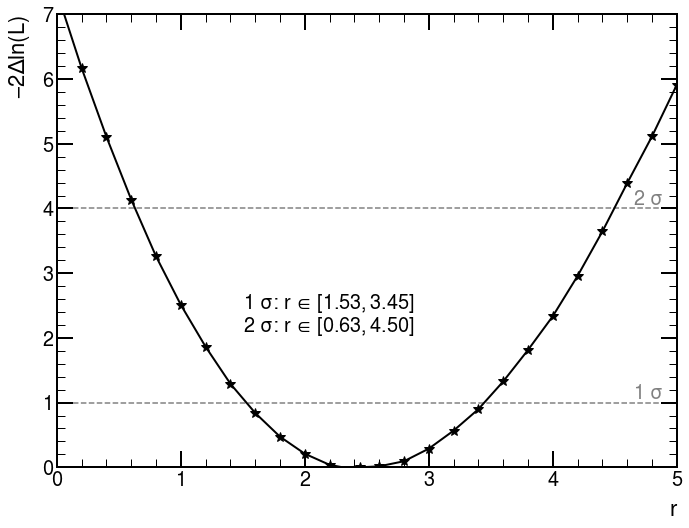

In [34]:
plotter = Likelihood1DPlot(df, styles={"plot":{"marker": "*", "markersize": 10}})
plotter.config['sigma_interval_styles']['loc'] = (0.3, 0.4)
plotter.draw(xattrib="r", xlabel="r", xmax=5, xmin=0, draw_sigma_intervals=True)

In [35]:
from quickstats.components import AnalysisBase
analysis = AnalysisBase(files["12538"], poi_name="r", data_name="data_obs", config={"eps": 0.1, "optimize": 1})

INFO: Opening file "/eos/atlas/unpledged/group-wisc/users/zhangr/Zy/cms/hzg/v1/12538/comb_hzg_plain.root"
INFO: Loaded workspace "w"
INFO: Loaded model config "ModelConfig"
INFO: Loaded model pdf "model_s" from model config
INFO: Loaded dataset "data_obs" from workspace
INFO: Loaded nuisance parameters from model config
INFO: Loaded global observables from model config
INFO: Loaded parameters of interest from model config
INFO: Loaded observables from model config
INFO: POI set to "r"
INFO: Created ExtendedMinimizer("Minimizer") instance


In [36]:
result = smart_scan(analysis, poi_min=0, poi_max=6, step=0.2,
                    cache_filename="mH_12538_mu_{poi_val}.json",
                    snapshot_name="mu_{poi_val}",
                    cache_workspace="mH_12538_cache_workspace.root",
                    outfile="mH_12538_<poi_name>.json")

INFO: Loading cached workspace.
INFO: Opening file "/afs/cern.ch/work/c/chlcheng/Repository/hzycombination/notebooks/likelihood_scan/cache/mH_12538_cache_workspace.root"
INFO: Loaded workspace "w"
INFO: Loaded model config "ModelConfig"
INFO: Loaded model pdf "model_s" from model config
INFO: Loaded dataset "data_obs" from workspace
INFO: Loaded nuisance parameters from model config
INFO: Loaded global observables from model config
INFO: Loaded parameters of interest from model config
INFO: Loaded observables from model config
INFO: POI set to "r"
INFO: Created ExtendedMinimizer("Minimizer") instance
INFO: Cached mu = uncond result from /afs/cern.ch/work/c/chlcheng/Repository/hzycombination/notebooks/likelihood_scan/cache/mH_12538_mu_uncond.json
INFO: Cached mu = 2p4 result from /afs/cern.ch/work/c/chlcheng/Repository/hzycombination/notebooks/likelihood_scan/cache/mH_12538_mu_2p4.json
INFO: Cached mu = 2p6 result from /afs/cern.ch/work/c/chlcheng/Repository/hzycombination/notebooks/lik

In [37]:
df = pd.DataFrame(result)

<AxesSubplot:xlabel='r', ylabel='$-2\\Delta ln(L)$'>

<Figure size 432x288 with 0 Axes>

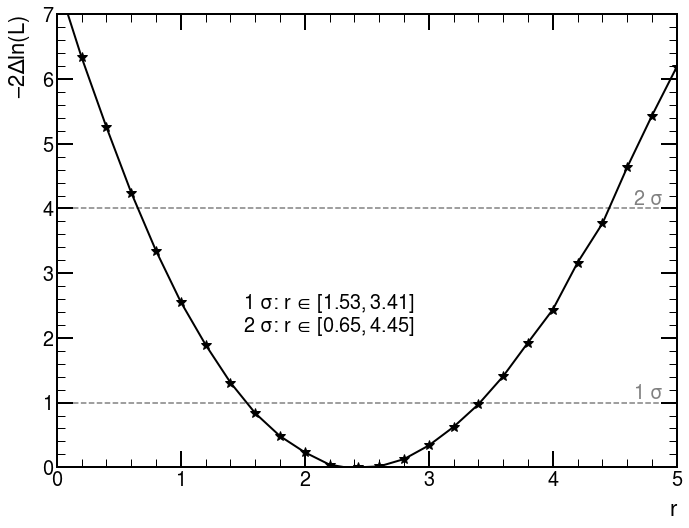

In [38]:
plotter = Likelihood1DPlot(df, styles={"plot":{"marker": "*", "markersize": 10}})
plotter.config['sigma_interval_styles']['loc'] = (0.3, 0.4)
plotter.draw(xattrib="r", xlabel="r", xmax=5, xmin=0, draw_sigma_intervals=True)